# AE [600]

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Download, Load & Foldering the Dataset

In [2]:
""" UTKFace dataset from https://susanqq.github.io/UTKFace/ """
# Move files from shared drive to my google drive --> https://youtu.be/XogiVzv6fEs?si=4Qvm0b7yU_gc3LTF
# !sudo cp -v -r "/content/drive/MyDrive/Datasets/part1.tar.gz" "/content/drive/MyDrive/Datasets/UTKFace_dataset"
# !sudo cp -v -r "/content/drive/MyDrive/Datasets/part2.tar.gz" "/content/drive/MyDrive/Datasets/UTKFace_dataset"
# !sudo cp -v -r "/content/drive/MyDrive/Datasets/part3.tar.gz" "/content/drive/MyDrive/Datasets/UTKFace_dataset"

' UTKFace dataset from https://susanqq.github.io/UTKFace/ '

In [3]:
# import os
# os.chdir('/content/drive/MyDrive/Datasets/UTKFace_dataset/')
# !pwd
# !ls -hal
# !sudo tar -xf /content/drive/MyDrive/Datasets/UTKFace_dataset/part1.tar.gz
# !sudo tar -xf /content/drive/MyDrive/Datasets/UTKFace_dataset/part2.tar.gz
# !sudo tar -xf /content/drive/MyDrive/Datasets/UTKFace_dataset/part3.tar.gz

In [4]:
# !sudo mv /content/drive/MyDrive/Datasets/UTKFace_dataset/part1/* /content/drive/MyDrive/Datasets/UTKFace_dataset/images/
# !sudo mv /content/drive/MyDrive/Datasets/UTKFace_dataset/part2/* /content/drive/MyDrive/Datasets/UTKFace_dataset/images/
# !sudo mv /content/drive/MyDrive/Datasets/UTKFace_dataset/part3/* /content/drive/MyDrive/Datasets/UTKFace_dataset/images/

In [2]:
import os
len(os.listdir('/content/drive/MyDrive/Datasets/UTKFace_dataset/images/'))

24108

> # **Labels**

- The labels of each face image is embedded in the file name, formated like [age]\_[gender]\_[race]_[date&time].jpg

- [age] is an integer from 0 to 116

- [gender] is either 0 (male) or 1 (female)

- [race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern)

- [date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

# Codes:

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random as rn
from tqdm import tqdm
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
dataset_path = "/content/drive/MyDrive/Datasets/UTKFace_dataset/images/"
imgsize = 300
all_images_status = True

if all_images_status:
  num = len(os.listdir(dataset_path))
else:
  num = 200

In [36]:
old_age_images = []
old_age_lst = []

o_gender_lst = []
o_race_lst = []
o_datetime_lst = []

young_age_images = []
young_age_lst = []

y_gender_lst = []
y_race_lst = []
y_datetime_lst = []

def importing_data(dir_path, num, imgsize=32):
    i = 0
    for file_name in tqdm(os.listdir(dir_path)):
        if num <= i:
          break
        i += 1

        file_name_bipass = os.path.splitext(file_name)[0] # remove passvandaaaa! :3 -.jpg
        label = file_name_bipass.split('_')
        age = int(label[0])

        if not 24 <= age <= 60:
            # young age range is between 15 to 24 --> https://www.un.org/en/global-issues/youth
            # old age ranges is between 60 to 80+ --> https://en.wikipedia.org/wiki/Old_age

            file_path = os.path.join(dir_path, file_name)
            image = cv2.imread(file_path, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (imgsize, imgsize))

            if image.shape[2] == 1:
                image.shape[2] = 3

            if 15 <= age <= 24: # young
                young_age_images.append(np.array(image))
                young_age_lst.append(age)

                if len(label) == 4:
                    y_gender_lst.append(int(label[1]))
                    y_race_lst.append(int(label[2]))
                    y_datetime_lst.append(int(label[3]))

            elif 60 <= age: # old
                old_age_images.append(np.array(image))
                old_age_lst.append(age)

                if len(label) == 4:
                    o_gender_lst.append(int(label[1]))
                    o_race_lst.append(int(label[2]))
                    o_datetime_lst.append(int(label[3]))
        # else:
        #   print(f'{file_name}: this age is not old or young!!!')

In [37]:
importing_data(dataset_path, num, imgsize)

100%|██████████| 24108/24108 [06:19<00:00, 63.48it/s] 


In [38]:
young_age_images = np.array(young_age_images)
young_age_array = np.array(young_age_lst)
y_gender_array = np.array(y_gender_lst)
y_race_array = np.array(y_race_lst)
y_datetime_array = np.array(y_datetime_lst)

old_age_images = np.array(old_age_images)
old_age_array = np.array(old_age_lst)
o_gender_array = np.array(o_gender_lst)
o_race_array = np.array(o_race_lst)
o_datetime_array = np.array(o_datetime_lst)

In [39]:
print(young_age_images.shape, '|', old_age_images.shape)
print(young_age_array.shape, '|', old_age_array.shape)

(2410, 300, 300, 3) | (2451, 300, 300, 3)
(2410,) | (2451,)


In [40]:
""" Equalizing the number of young and old images """
if young_age_images.shape[0] > old_age_images.shape[0]:
    young_age_images = young_age_images[:old_age_images.shape[0]]
    young_age_array = young_age_array[:old_age_array.shape[0]]
else:
    old_age_images = old_age_images[:young_age_images.shape[0]]
    old_age_array = old_age_array[:young_age_array.shape[0]]

print(young_age_images.shape, '|', old_age_images.shape)
print(young_age_array.shape, '|', old_age_array.shape)

(2410, 300, 300, 3) | (2410, 300, 300, 3)
(2410,) | (2410,)


In [ ]:
# del dataset_path, all_images_status, num, young_age_lst, y_gender_lst, y_race_lst, y_datetime_lst, old_age_lst, o_gender_lst, o_race_lst, o_datetime_lst

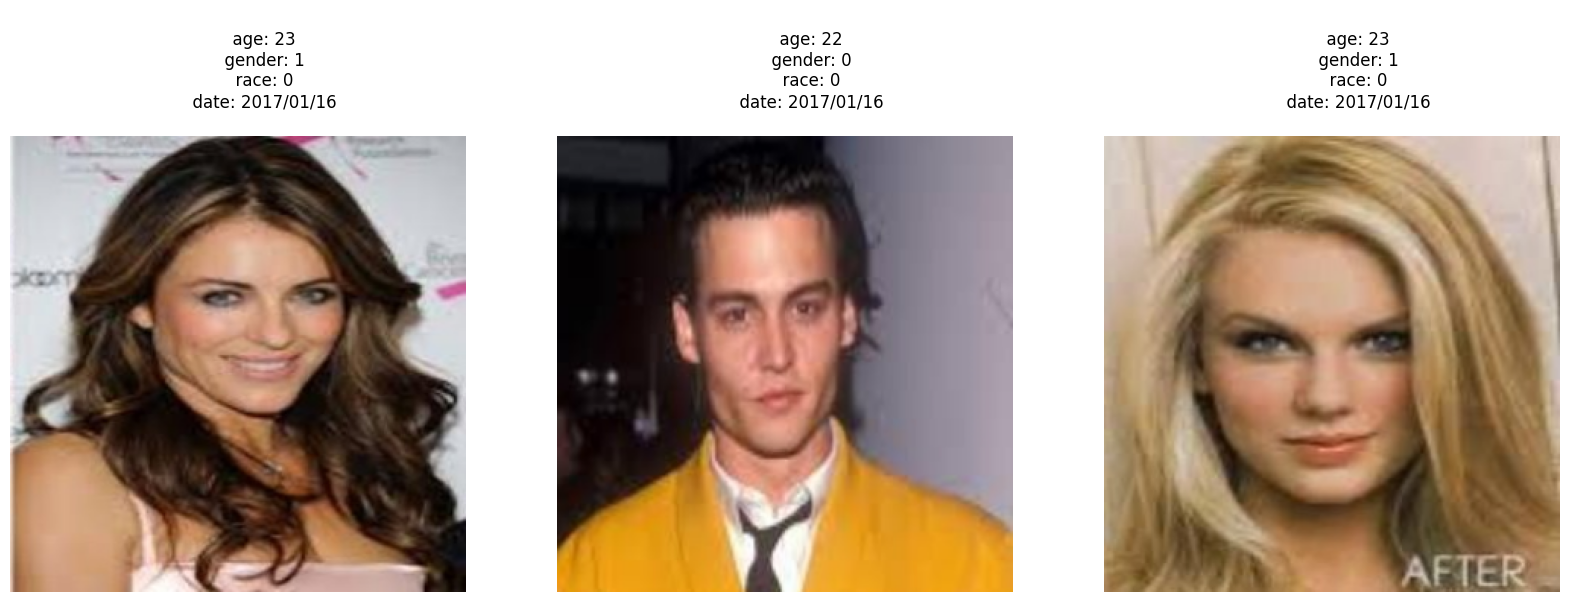

In [62]:
fig1 = plt.figure(figsize=(3, 1))
fig1.set_size_inches(20, 20, forward=True)

num_samples = 3
for i, img in enumerate(young_age_images[0:num_samples]):
    fig1.add_subplot(1, num_samples, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(
         f"""
          age: {young_age_array[i]}
          gender: {y_gender_array[i]}
          race: {y_race_array[i]}
          date: {str(y_datetime_array[i])[:4]}/{str(y_datetime_array[i])[4:6]}/{str(y_datetime_array[i])[6:8]}
          """,
         fontsize = 12
        ) # 0 (male) or 1 (female) --- 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern)


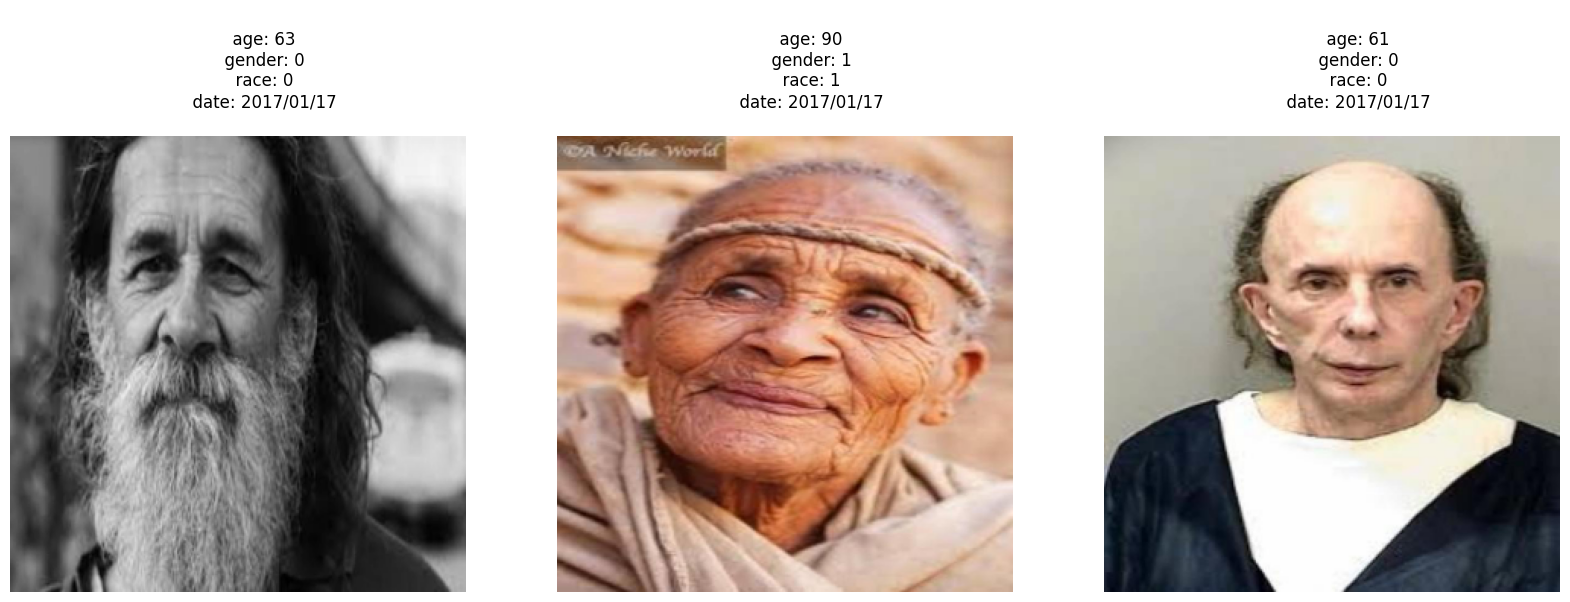

In [63]:
fig2 = plt.figure(figsize=(3, 1))
fig2.set_size_inches(20, 20, forward=True)

for i, img in enumerate(old_age_images[0:num_samples]):
    fig2.add_subplot(1, num_samples, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(
         f"""
          age: {old_age_array[i]}
          gender: {o_gender_array[i]}
          race: {o_race_array[i]}
          date: {str(o_datetime_array[i])[:4]}/{str(o_datetime_array[i])[4:6]}/{str(o_datetime_array[i])[6:8]}
          """
        ) # 0 (male) or 1 (female) --- 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern)

In [64]:
""" split train and test data """
train_young_images, test_young_images, train_young_labels, test_young_labels = train_test_split(young_age_images, young_age_array, test_size=0.2, random_state=123)
train_old_images, test_old_images, train_old_labels, test_old_labels = train_test_split(old_age_images, old_age_array, test_size=0.2, random_state=123)

In [65]:
print(train_young_images.shape)
print(train_young_labels.shape)

print(test_young_images.shape)
print(test_young_labels.shape)

print(train_old_images.shape)
print(train_old_labels.shape)

print(test_old_images.shape)
print(test_old_labels.shape)

(1928, 300, 300, 3)
(1928,)
(482, 300, 300, 3)
(482,)
(1928, 300, 300, 3)
(1928,)
(482, 300, 300, 3)
(482,)


In [66]:
""" Normalize pixel values """
train_young_images = train_young_images / 255.0
test_young_images = test_young_images / 255.0

train_old_images = train_old_images / 255.0
test_old_images = test_old_images / 255.0

In [67]:
def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return autoencoder

autoencoder = build_autoencoder(train_young_images.shape[1:])

In [71]:
""" Early stopping callback """
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [72]:
history = autoencoder.fit(
    train_young_images,
    train_old_images,
    epochs=25,
    batch_size=32,
    shuffle=True,
    validation_data=[test_old_images, test_young_images],
    callbacks=[early_stopping]
  )

Epoch 1/25
61/61 [==============================] - 168s 3s/step - loss: 0.0818 - accuracy: 0.6857 - val_loss: 0.0895 - val_accuracy: 0.7071
Epoch 2/25
61/61 [==============================] - 165s 3s/step - loss: 0.0816 - accuracy: 0.6852 - val_loss: 0.0894 - val_accuracy: 0.7067
Epoch 3/25
61/61 [==============================] - 166s 3s/step - loss: 0.0815 - accuracy: 0.6837 - val_loss: 0.0896 - val_accuracy: 0.7067
Epoch 4/25
61/61 [==============================] - 166s 3s/step - loss: 0.0815 - accuracy: 0.6854 - val_loss: 0.0893 - val_accuracy: 0.7071
Epoch 5/25
61/61 [==============================] - 167s 3s/step - loss: 0.0814 - accuracy: 0.6862 - val_loss: 0.0893 - val_accuracy: 0.7069
Epoch 6/25
61/61 [==============================] - 167s 3s/step - loss: 0.0815 - accuracy: 0.6858 - val_loss: 0.0893 - val_accuracy: 0.7070
Epoch 7/25
61/61 [==============================] - 167s 3s/step - loss: 0.0814 - accuracy: 0.6857 - val_loss: 0.0896 - val_accuracy: 0.7070
Epoch 8/25
61

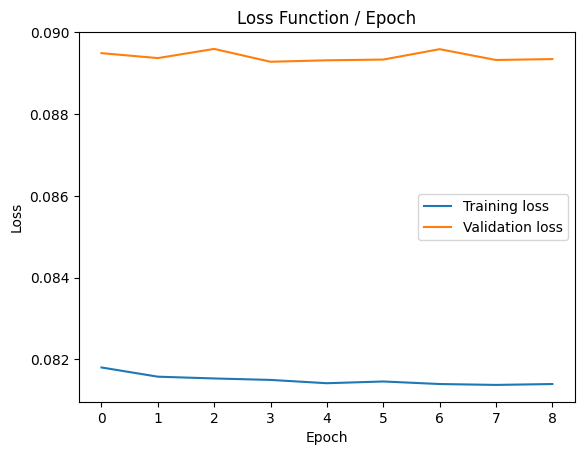

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 150, 150, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 75, 75, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 75, 75, 64)        3692

In [73]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss Function / Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

autoencoder.summary()

In [75]:
autoencoder.evaluate(x=test_young_images, y=test_old_images)

16/16 [==============================] - 5s 317ms/step - loss: 0.0807 - accuracy: 0.6593


[0.08072786778211594, 0.659331202507019]

## THNAK YOU --- \\(^o^)/